## **COVID-19 Diagnosis Using Chest X-Ray Data**
This project uses Chest X-Ray Data to train a deep neural network to help diagnose COVID-19.

### Introduction
COVID-19 is severely impacting the health of countless people worldwide. A crucial step in controlling the disease has been early detection of infected patients, which can be achieved through radiography, according to prior literature that shows COVID-19 causes chest abnormalities noticeable in chest X-rays.

We begin by importing necessary packages for our model.


In [4]:
import cv2
import os
import numpy as np

###Data Collection
There is no substantially-sized, clinically verified, and publicly available COVID-19 dataset. However, a small composite dataset with X-Rays of COVID-19 positive patients recently became publicly available with [DeepCovid](https://github.com/shervinmin/DeepCovid), which compiled their data from:

[Covid-Chestxray-Dataset](https://github.com/ieee8023/covid-chestxray-dataset) for COVID-19 X-ray samples

[ChexPert Dataset](https://stanfordmlgroup.github.io/competitions/chexpert/) for Non-COVID samples


Our data was stored on a google drive so we will mount the drive to get the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from zipfile import ZipFile

file_name = 'drive/My Drive/dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Data extracted!")

Data extracted!


Next, let us begin feature and label building. We can utilize Paths to 
list the directory of every X-Ray from the dataset.

In [7]:
from imutils import paths

data = []
labels = []

# Grab list of image paths using paths.list_images
imagePaths = list(paths.list_images('dataset/covid')) + list(paths.list_images('dataset/normal'))

# Label and resize the images 

for imagePath in imagePaths:
	# extract the class label from the filename
    if imagePath[8] == 'c':
	    label = 'covid'
    else:
        label = 'normal'

    image = cv2.imread(imagePath)
    image = cv2.resize(image, (224, 224))

    data.append(image)
    labels.append(label)


# Convert data and labels to a Numpy Array and normalize the pixel values
data = np.array(data) / 255.0
labels = np.array(labels)

Use SKLearn to one-hot encode our labels.

In [8]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

### Data Splitting
Now that we're done grabbing our data, we can begin to look at splitting the data into our training and validation sets.

In [10]:
from sklearn.model_selection import train_test_split
# Partition data into 80% training and 20% validation

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.20)

### Set hyperparameters

In [11]:
EPOCHS = 20
BATCH_SIZE = 16
LR = 1e-4

### Base model
We are gonna use ResNet as the base model. The pretrained weights come from imagenet, and our input is (224,224,3).

In [33]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Input

base = ResNet152V2(include_top=False, weights = 'imagenet', input_shape = (224,224,3))

base.summary()

234553344/234545216 [==============================] - 4s 0us/step
Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_____________________

###Build Model###
We will construct our model here.

In [42]:
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.losses import categorical_crossentropy

#Construct structure after ResNet
head = base.output
head = AveragePooling2D(pool_size=(7,7))(head)
head = BatchNormalization()(head)
head = Flatten()(head)
head = Dense(128, activation='relu')(head)
head = Dense(2, activation='sigmoid')(head)

# Combine the model
model = Model(inputs=base.input, outputs=head)

# Freeze base layers
base.trainable = False

# Compile the model
model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate = LR), metrics=['accuracy'])

### Data augmentation
Use data augmentation object for our training set to make the model more robust.

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainAug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

###Training


In [44]:
# Add Earlystopping to monitor validation loss
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 5)

In [45]:
# Train model
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BATCH_SIZE), 
    validation_data = (testX, testY), 
    steps_per_epoch=len(trainX) // BATCH_SIZE, 
    epochs = EPOCHS,
    callbacks = [callback]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
103/103 [==============================] - 26s 183ms/step - loss: 0.6089 - accuracy: 0.7145 - val_loss: 0.4417 - val_accuracy: 0.7821
Epoch 2/20
103/103 [==============================] - 17s 162ms/step - loss: 0.3022 - accuracy: 0.8800 - val_loss: 0.2677 - val_accuracy: 0.8910
Epoch 3/20
103/103 [==============================] - 17s 163ms/step - loss: 0.2339 - accuracy: 0.9103 - val_loss: 0.2290 - val_accuracy: 0.9128
Epoch 4/20
103/103 [==============================] - 17s 162ms/step - loss: 0.2217 - accuracy: 0.9146 - val_loss: 0.1895 - val_accuracy: 0.9346
Epoch 5/20
103/103 [==============================] - 17s 165ms/step - loss: 0.1890 - accuracy: 0.9233 - val_loss: 0.1672 - val_accuracy: 0.9467
Epoch 6/20
103/103 [==============================] - 17s 162ms/step - loss: 0.1843 - accuracy: 0.9209 - val_loss: 0.1650 - val_accuracy: 0.9370
Epoch 7/20
103/103 [==============================] - 17s 163ms/step - loss: 0.1648 - accuracy: 0.9396 - val_loss: 0.1413 - val_ac

### Predictions
Here are some important metrics to see how well our model performs on the test set.

In [46]:
from sklearn.metrics import classification_report

predIdxs = np.argmax(model.predict(testX, batch_size=BATCH_SIZE), axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       0.99      0.93      0.96       169
      normal       0.96      1.00      0.98       244

    accuracy                           0.97       413
   macro avg       0.98      0.97      0.97       413
weighted avg       0.97      0.97      0.97       413



We can also compute the confusion matrix to find the sensitivity and specificity.

In [47]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
print(cm)

#TODO: compute sensitivity and specificity from confusion matrix
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[158  11]
 [  1 243]]
sensitivity: 0.9349
specificity: 0.9959


### Visualization
Visualize loss and accuracy metrics.

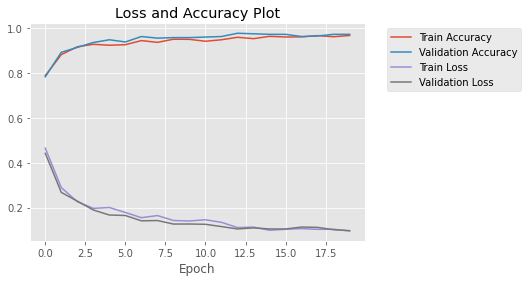

In [48]:
import matplotlib.pyplot as plt


N = len(H.history['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="Validation Accuracy")
plt.plot(np.arange(0, N), H.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig("performance_plot.png")